In [1]:
import pandas as pd
import numpy as np

# 데이터 불러오기
data1 = pd.read_csv('WallThining_data.csv')
data2 = pd.read_csv('WallThinning_3050_data.csv')
data3 = pd.read_csv('WallThinning_10_data.csv')
data = pd.concat([data1, data2, data3], axis=0)
data = data.drop('Moment', axis=1).reset_index(drop=True)
# 데이터 확인
print(data.head())

  Thining Part Moment Direction Thining Rate Boundary Type  Inner Pressure  \
0        Extra              IPO          20%    Limit Load          22.070   
1        Extra              IPO          20%    Limit Load          19.863   
2        Extra              IPO          20%    Limit Load          17.656   
3        Extra              IPO          20%    Limit Load          15.449   
4        Extra              IPO          20%    Limit Load          13.242   

   Multiplier  
0    0.754368  
1    0.889164  
2    1.000607  
3    1.022539  
4    0.970476  


In [2]:
len(data1), len(data2), len(data3)

(594, 396, 198)

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max Scaler 객체 생성
scaler = MinMaxScaler()

# 'Inner Pressure' 열 선택 및 Reshape (-1, 1) 필요 (scaler는 2D 배열을 요구함)
inner_Pressure = data['Inner Pressure'].values.reshape(-1, 1)

# Min-Max Normalization 적용
data['Inner Pressure'] = scaler.fit_transform(inner_Pressure)

# 결과 확인
print(data.head())

  Thining Part Moment Direction Thining Rate Boundary Type  Inner Pressure  \
0        Extra              IPO          20%    Limit Load             1.0   
1        Extra              IPO          20%    Limit Load             0.9   
2        Extra              IPO          20%    Limit Load             0.8   
3        Extra              IPO          20%    Limit Load             0.7   
4        Extra              IPO          20%    Limit Load             0.6   

   Multiplier  
0    0.754368  
1    0.889164  
2    1.000607  
3    1.022539  
4    0.970476  


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Categorical 변수 인코딩
# le = LabelEncoder()
# data['Thining Part'] = le.fit_transform(data['Thining Part'])
# data['Moment Direction'] = le.fit_transform(data['Moment Direction'])
# data['Boundary Type'] = le.fit_transform(data['Boundary Type'])

data = pd.get_dummies(data, columns=['Thining Part','Moment Direction','Boundary Type'])

# Numerical 변수 전처리 (Inner pressure)
data['Thining Rate'] = data['Thining Rate'].str.rstrip('%').astype('int')

# 데이터 분할
X = data.drop('Multiplier', axis=1)
y = data['Multiplier']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

주성분별 설명된 분산 비율: [0.99341508 0.001703  ]


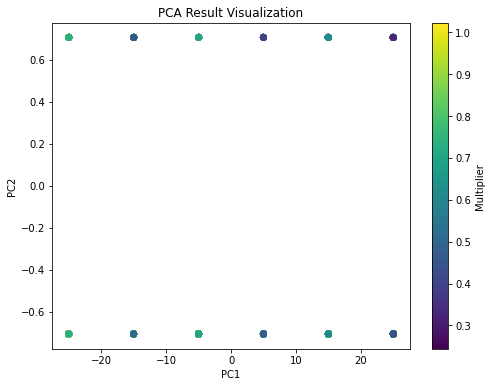

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA 객체 생성 (주성분 수 설정)
pca = PCA(n_components=2)

# PCA 수행
X_pca = pca.fit_transform(X)

# 주성분별 설명된 분산 비율 확인
explained_variance_ratio = pca.explained_variance_ratio_
print("주성분별 설명된 분산 비율:", explained_variance_ratio)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Multiplier'] = data['Multiplier']

# PCA 결과 시각화
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Multiplier'], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter, label='Multiplier')
plt.title('PCA Result Visualization')
plt.show()

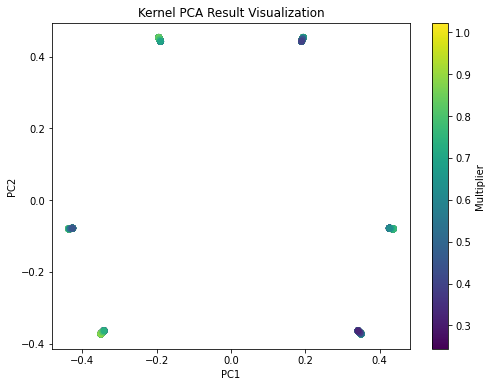

In [25]:
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt

# 커널 PCA 객체 생성
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=None)

# 커널 PCA 수행
X_kpca = kpca.fit_transform(X)

# 커널 PCA 결과를 데이터프레임으로 변환
kpca_df = pd.DataFrame(data=X_kpca, columns=['PC1', 'PC2'])
kpca_df['Multiplier'] = data['Multiplier']

# 커널 PCA 결과 시각화
plt.figure(figsize=(8, 6))
scatter = plt.scatter(kpca_df['PC1'], kpca_df['PC2'], c=kpca_df['Multiplier'], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter, label='Multiplier')
plt.title('Kernel PCA Result Visualization')
plt.show()

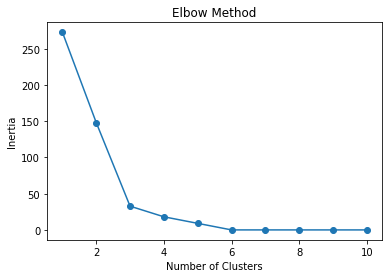

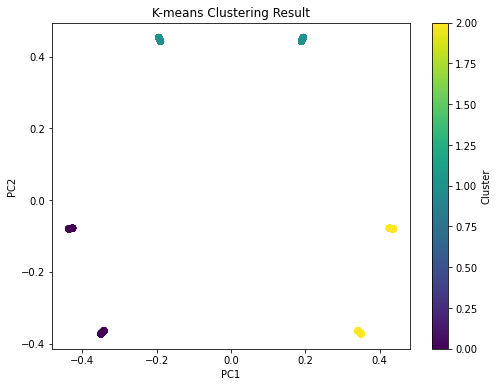

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 최적의 클러스터 개수 찾기
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_kpca)
    inertia.append(kmeans.inertia_)

# Elbow 그래프 그리기
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# 최적의 클러스터 개수 선택 (예: 3)
n_clusters = 3

# K-means 클러스터링 수행
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_kpca)

# 클러스터링 결과를 데이터프레임에 추가
kpca_df['Cluster'] = cluster_labels

# 클러스터링 결과 시각화
plt.figure(figsize=(8, 6))
scatter = plt.scatter(kpca_df['PC1'], kpca_df['PC2'], c=kpca_df['Cluster'], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter, label='Cluster')
plt.title('K-means Clustering Result')
plt.show()

In [30]:
# 클러스터링 결과를 원본 데이터프레임에 추가
data['Cluster'] = cluster_labels

# 클러스터별 특성 확인
for cluster in range(n_clusters):
    cluster_data = data[data['Cluster'] == cluster]
    print(f'Cluster {cluster}:')
    print(cluster_data.describe())
    print()

Cluster 0:
       Thining Rate  Inner Pressure  Multiplier  Thining Part_Crown  \
count    396.000000      396.000000  396.000000          396.000000   
mean      15.000000        0.500000    0.693787            0.333333   
std        5.006325        0.316628    0.162687            0.472001   
min       10.000000        0.000000    0.326220            0.000000   
25%       10.000000        0.200000    0.571887            0.000000   
50%       15.000000        0.500000    0.718690            0.000000   
75%       20.000000        0.800000    0.815901            1.000000   
max       20.000000        1.000000    1.023133            1.000000   

       Thining Part_Extra  Thining Part_Intra  Moment Direction_IPC  \
count          396.000000          396.000000            396.000000   
mean             0.333333            0.333333              0.333333   
std              0.472001            0.472001              0.472001   
min              0.000000            0.000000              0.0000

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow import keras

models = {
    'MLP': Sequential([
        Dense(64, activation='relu', input_shape=(10,)),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ]),
    'CNN': Sequential([
        # Conv1D는 3D 입력이 필요하므로 (샘플 수, 타임스텝, 특성) 형태로 변환 필요
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(10, 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1, activation='linear')
    ]),
    'RNN': Sequential([
        SimpleRNN(50, activation='relu', input_shape=(10, 1)),
        Dense(1, activation='linear')
    ]),
    'LSTM': Sequential([
        LSTM(50, activation='relu', input_shape=(10, 1)),
        Dense(1, activation='linear')
    ]),
    'GRU': Sequential([
        GRU(50, activation='relu', input_shape=(10, 1)),
        Dense(1, activation='linear')
    ])
}

# MAPE와 SMAPE 함수 정의
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2)) * 100


# 모델 컴파일 및 학습
for name, model in models.items():
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    if name == 'MLP':
        model.fit(X_train, y_train, validation_split=0.2, epochs=10, callbacks=[early_stop], verbose=0)
        y_pred = model.predict(X_test)
    else:
        X_train_transformed = X_train.to_numpy().reshape((X_train.shape[0], X_train.shape[1], 1))
        model.fit(X_train_transformed, y_train, validation_split=0.2, epochs=10, callbacks=[early_stop], verbose=0)
        X_test_transformed = X_test.to_numpy().reshape((X_test.shape[0], X_test.shape[1], 1))
        y_pred = model.predict(X_test_transformed)

    # 실제 값과 예측 값의 차이를 계산하여 평가 지표를 구함
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)   
    r2 = r2_score(y_test, y_pred)

    print(f'{name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}, SMAPE: {smape:.4f}, R2: {r2:.4f}')

MLP - MAE: 0.1472, MSE: 0.0318, RMSE: 0.1782, MAPE: 25.7255, SMAPE: 25.6028, R2: -0.2587
CNN - MAE: 0.0684, MSE: 0.0071, RMSE: 0.0845, MAPE: 27.5107, SMAPE: 26.5246, R2: 0.7170
RNN - MAE: 0.1108, MSE: 0.0172, RMSE: 0.1313, MAPE: 24.8060, SMAPE: 22.7702, R2: 0.3172
LSTM - MAE: 0.0933, MSE: 0.0139, RMSE: 0.1178, MAPE: 25.3472, SMAPE: 22.9806, R2: 0.4506
GRU - MAE: 0.1141, MSE: 0.0201, RMSE: 0.1419, MAPE: 25.3210, SMAPE: 21.8315, R2: 0.2017


In [ ]:
data_10 = data[data['Thining Rate'] == 10]
X_test = data_10.drop('Multiplier', axis=1)
y_test = data_10['Multiplier']

# data_10 = data[data['Thining Rate'] == 10]


# 모델 컴파일 및 학습
for name, model in models.items():
    if name == 'MLP':
        y_pred = model.predict(X_test)
    else:
        X_test_transformed = X_test.to_numpy().reshape((X_test.shape[0], X_test.shape[1], 1))
        y_pred = model.predict(X_test_transformed)

    # 실제 값과 예측 값의 차이를 계산하여 평가 지표를 구함
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)   
    r2 = r2_score(y_test, y_pred)
    
    print(f'{name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}, SMAPE: {smape:.4f}, R2: {r2:.4f}')

MLP - MAE: 0.0824, MSE: 0.0101, RMSE: 0.1005, MAPE: 27.3844, SMAPE: 24.0907, R2: 0.6207
CNN - MAE: 0.0783, MSE: 0.0093, RMSE: 0.0966, MAPE: 25.4266, SMAPE: 23.3310, R2: 0.6498
RNN - MAE: 0.1294, MSE: 0.0229, RMSE: 0.1514, MAPE: 23.7018, SMAPE: 22.4303, R2: 0.1399
LSTM - MAE: 0.1270, MSE: 0.0228, RMSE: 0.1512, MAPE: 22.4460, SMAPE: 20.6219, R2: 0.1426
GRU - MAE: 0.1288, MSE: 0.0230, RMSE: 0.1516, MAPE: 22.9349, SMAPE: 20.6627, R2: 0.1378


In [7]:
data_60 = data[data['Thining Rate'] == 60]
X_test = data_60.drop('Multiplier', axis=1)
y_test = data_60['Multiplier']

# data_60 = data[data['Thining Rate'] == 60]


# 모델 컴파일 및 학습
for name, model in models.items():
    if name == 'MLP':
        y_pred = model.predict(X_test)
    else:
        X_test_transformed = X_test.to_numpy().reshape((X_test.shape[0], X_test.shape[1], 1))
        y_pred = model.predict(X_test_transformed)

    # 실제 값과 예측 값의 차이를 계산하여 평가 지표를 구함
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)   
    r2 = r2_score(y_test, y_pred)
    
    print(f'{name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}, SMAPE: {smape:.4f}, R2: {r2:.4f}')

MLP - MAE: 0.1132, MSE: 0.0206, RMSE: 0.1435, MAPE: 32.5123, SMAPE: 26.0796, R2: -0.0757
CNN - MAE: 0.0899, MSE: 0.0124, RMSE: 0.1112, MAPE: 29.1831, SMAPE: 25.0307, R2: 0.3542
RNN - MAE: 0.0968, MSE: 0.0135, RMSE: 0.1162, MAPE: 24.8847, SMAPE: 22.0737, R2: 0.2952
LSTM - MAE: 0.1044, MSE: 0.0171, RMSE: 0.1306, MAPE: 21.0341, SMAPE: 19.6271, R2: 0.1095
GRU - MAE: 0.1084, MSE: 0.0181, RMSE: 0.1347, MAPE: 24.8348, SMAPE: 20.7766, R2: 0.0525


In [21]:
import pandas as pd
import numpy as np

# 데이터 불러오기
data = pd.read_csv('WallThinning_10_data.csv')
data = data.drop('Moment', axis=1)
# 데이터 확인
print(data.head())

  Thining Part Moment Direction Thining Rate      Boundary Type  \
0        Intra              IPO          10%  Elastic Shakedown   
1        Intra              IPO          10%  Elastic Shakedown   
2        Intra              IPO          10%  Elastic Shakedown   
3        Intra              IPO          10%  Elastic Shakedown   
4        Intra              IPO          10%  Elastic Shakedown   

   Inner Pressure  Multiplier  
0           0.000    0.358500  
1           2.207    0.398348  
2           4.414    0.448171  
3           6.621    0.512240  
4           8.828    0.597668  


In [22]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max Scaler 객체 생성
scaler = MinMaxScaler()

# 'Inner Pressure' 열 선택 및 Reshape (-1, 1) 필요 (scaler는 2D 배열을 요구함)
inner_Pressure = data['Inner Pressure'].values.reshape(-1, 1)

# Min-Max Normalization 적용
data['Inner Pressure'] = scaler.fit_transform(inner_Pressure)

# 결과 확인
print(data.head())


  Thining Part Moment Direction Thining Rate      Boundary Type  \
0        Intra              IPO          10%  Elastic Shakedown   
1        Intra              IPO          10%  Elastic Shakedown   
2        Intra              IPO          10%  Elastic Shakedown   
3        Intra              IPO          10%  Elastic Shakedown   
4        Intra              IPO          10%  Elastic Shakedown   

   Inner Pressure  Multiplier  
0             0.0    0.358500  
1             0.1    0.398348  
2             0.2    0.448171  
3             0.3    0.512240  
4             0.4    0.597668  


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

data = pd.get_dummies(data, columns=['Thining Part','Moment Direction','Boundary Type'])

# Numerical 변수 전처리 (Inner pressure)
data['Thining Rate'] = data['Thining Rate'].str.rstrip('%').astype('int')

# 데이터 분할
X = data.drop('Multiplier', axis=1)
y = data['Multiplier']

In [24]:
# 모델 컴파일 및 학습
for name, model in models.items():
    if name == 'MLP':
        y_pred = model.predict(X)
    else:
        X_transformed = X.to_numpy().reshape((X.shape[0], X.shape[1], 1))
        y_pred = model.predict(X_transformed)

    # 실제 값과 예측 값의 차이를 계산하여 평가 지표를 구함
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y, y_pred)   
    r2 = r2_score(y, y_pred)

    print(f'{name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}, SMAPE: {smape:.4f}, R2: {r2:.4f}')

MLP - MAE: 0.2525, MSE: 0.0878, RMSE: 0.2963, MAPE: 35.1640, SMAPE: 44.3540, R2: -2.2957
CNN - MAE: 0.0884, MSE: 0.0121, RMSE: 0.1100, MAPE: 24.8646, SMAPE: 24.9010, R2: 0.5458
RNN - MAE: 0.1324, MSE: 0.0232, RMSE: 0.1523, MAPE: 22.8914, SMAPE: 21.4570, R2: 0.1295
LSTM - MAE: 0.1441, MSE: 0.0296, RMSE: 0.1721, MAPE: 23.9015, SMAPE: 25.3037, R2: -0.1117
GRU - MAE: 0.1360, MSE: 0.0246, RMSE: 0.1569, MAPE: 22.5387, SMAPE: 21.3912, R2: 0.0766
